# Scraping FOMC Statements since 2000

In [1]:
import requests                 
import bs4 
import re
import time
import random
import pandas as pd
import csv
from datetime import datetime
import nltk
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gen_soup_bs4(url):
    '''takes a url and returns a soup object'''
    
    headers = {'User-Agent': 'Mozilla/5.0 (Linux; Android 5.1.1; SM-G928X Build/LMY47X) ' + \
                              'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.83 Mobile Safari/537.36',
              "Accept-Encoding":"gzip, deflate", 
              "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", 
              "DNT":"1","Connection":"close", 
              "Upgrade-Insecure-Requests":"1"}

    response = requests.get(url = url, headers = headers)
    print("The response code is: ", response.status_code) 
    assert response.status_code == 200 #need to be 200 (ideally)
    soup = bs4.BeautifulSoup(response.text, "html.parser")
    time.sleep(1)
    
    return soup

In [3]:
def generate_absolute_url(relative_url):
    '''get absolute URL from relative URL'''
    
    domain = 'https://www.federalreserve.gov'
    return domain + relative_url
    

In [4]:
def split_and_treat(input_str):
    input_str = input_str.replace("'", '')
    input_str = input_str.replace('.', '. ')
    split_sentences = nltk.sent_tokenize(input_str)

    punc = "'.',',','?','(',')','%','$','#','!'"
    for i in range(len(split_sentences)):
        sent = split_sentences[i]
        for j in sent:
            if j in punc:
                sent = sent.replace(j, "")

        split_sentences[i] = sent.lower()
    return split_sentences


def sentence_tone(line_item):
    tone = 'none'
    ssent = line_item.split(' ')
    for word in ssent:
        if word in df_keywords.iat[0, 3]:
            tone = 'hawkish'
            return tone
        else:
            if word in df_keywords.iat[0, 2]:
                tone = 'dovish'

    return tone


def statement_tone(input_item):
    output_item = []
    for line_item in input_item:
        output_item.append(sentence_tone(line_item))
    return output_item


def sentence_positivity(line_item):
    y = line_item.split(' ')
    positivity = 0
    for ii in range(len(y)):
        if y[ii] in df_keywords.iat[0, 0]:
            if y[ii - 1] not in df_keywords.iat[0, 4] \
                    and y[ii - 2] not in df_keywords.iat[0, 4] \
                    and y[ii - 3] not in df_keywords.iat[0, 4]:
                positivity = positivity - 1
            else:
                positivity = positivity + 1
        if y[ii] in df_keywords.iat[0, 1]:
            if y[ii - 1] not in df_keywords.iat[0, 4]:
                positivity = positivity + 1
            else:
                positivity = positivity - 1

    return positivity


def statement_positivity(input_item):
    output_item = []
    for line_item in input_item:
        output_item.append(sentence_positivity(line_item))
    return output_item


def get_tadle_score(row):
    tone = row['tones']
    pos = row['positivity']

    for k in range(len(pos)):
        if tone[k] == 'none':
            pos[k] = 420

    tone_list = [item for item in tone if 'none' not in item]
    pos_list = [item for item in pos if item != 420]

    total = 0
    sent_num = len(tone_list)

    for i in range(len(tone_list)):
        if pos_list[i] != 0:
            if tone_list[i] == 'hawkish':
                if pos_list[i] > 0:
                    total = total + 1
                else:
                    total = total - 1
            else:
                if pos_list[i] > 0:
                    total = total - 1
                else:
                    total = total + 1

    return 100 * (total / sent_num)


def calc_distance(inp):
    myear = df[df['tadle_score'] == min(df['tadle_score'])].index.values[1]
    smin = df['full_text'].loc[myear]
    inp = inp.replace("'", '')
    smin = smin.replace("'", '')
    out_put = nltk.jaccard_distance(set(smin), set(inp))

    return (out_put * 75 / 0.4) * 2 - 75

# Scraping URLs for Press Releases

In [5]:
#get all URLs pre 2016

seed_url = 'https://www.federalreserve.gov/monetarypolicy/fomchistorical{}.htm'
pre2016 = [seed_url.format(n) for n in range(2000, 2017)]
pre2016

['https://www.federalreserve.gov/monetarypolicy/fomchistorical2000.htm',
 'https://www.federalreserve.gov/monetarypolicy/fomchistorical2001.htm',
 'https://www.federalreserve.gov/monetarypolicy/fomchistorical2002.htm',
 'https://www.federalreserve.gov/monetarypolicy/fomchistorical2003.htm',
 'https://www.federalreserve.gov/monetarypolicy/fomchistorical2004.htm',
 'https://www.federalreserve.gov/monetarypolicy/fomchistorical2005.htm',
 'https://www.federalreserve.gov/monetarypolicy/fomchistorical2006.htm',
 'https://www.federalreserve.gov/monetarypolicy/fomchistorical2007.htm',
 'https://www.federalreserve.gov/monetarypolicy/fomchistorical2008.htm',
 'https://www.federalreserve.gov/monetarypolicy/fomchistorical2009.htm',
 'https://www.federalreserve.gov/monetarypolicy/fomchistorical2010.htm',
 'https://www.federalreserve.gov/monetarypolicy/fomchistorical2011.htm',
 'https://www.federalreserve.gov/monetarypolicy/fomchistorical2012.htm',
 'https://www.federalreserve.gov/monetarypolicy/fom

In [6]:
#get all pre2016 statements URL

pre2016_statements_url = []

for url in pre2016:
    soup = gen_soup_bs4(url)
    for i in soup.find_all('a', {'href': re.compile(r'\/\w+\/press\w*\/')}):  
        if i.text.lower() == 'statement':
            statement_url = generate_absolute_url(i['href'])
            pre2016_statements_url.append(statement_url)
            
pre2016_statements_url

The response code is:  200
The response code is:  200
The response code is:  200
The response code is:  200
The response code is:  200
The response code is:  200
The response code is:  200
The response code is:  200
The response code is:  200
The response code is:  200
The response code is:  200
The response code is:  200
The response code is:  200
The response code is:  200
The response code is:  200
The response code is:  200
The response code is:  200


['https://www.federalreserve.gov/boarddocs/press/general/2000/20000202/',
 'https://www.federalreserve.gov/boarddocs/press/general/2000/20000321/',
 'https://www.federalreserve.gov/boarddocs/press/general/2000/20000516/',
 'https://www.federalreserve.gov/boarddocs/press/general/2000/20000628/',
 'https://www.federalreserve.gov/boarddocs/press/general/2000/20000822/',
 'https://www.federalreserve.gov/boarddocs/press/general/2000/20001003/',
 'https://www.federalreserve.gov/boarddocs/press/general/2000/20001115/',
 'https://www.federalreserve.gov/boarddocs/press/general/2000/20001219/',
 'https://www.federalreserve.gov/boarddocs/press/general/2001/20010103/',
 'https://www.federalreserve.gov/boarddocs/press/general/2001/20010131/',
 'https://www.federalreserve.gov/boarddocs/press/general/2001/20010320/',
 'https://www.federalreserve.gov/boarddocs/press/general/2001/20010418/',
 'https://www.federalreserve.gov/boarddocs/press/general/2001/20010515/',
 'https://www.federalreserve.gov/board

In [55]:
#get URLs for statements after 2017

seed_url_2017 = 'https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm'
soup_post2017 = gen_soup_bs4(seed_url_2017)

post2017_statements_url = []
for i in soup_post2017.find_all('a', {'href': re.compile(r'\/newsevents\/pressreleases\/')}):
    if i.text.lower() == 'html': #just get the statements
        statement_url = generate_absolute_url(i['href'])
        post2017_statements_url.append(statement_url)
        
post2017_statements_url.remove('https://www.federalreserve.gov/newsevents/pressreleases/monetary20221102a.htm')

post2017_statements_url

The response code is:  200


['https://www.federalreserve.gov/newsevents/pressreleases/monetary20220126a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220316a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220504a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220615a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220727a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220921a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20210127a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20210317a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20210428a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20210616a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20210728a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20210922a.htm',
 'https://www.fe

In [57]:
#federal reserve website structure change after 2006. So, need to scrap separately

all_urls = pre2016_statements_url + post2017_statements_url
pre2006 = all_urls[:51]
post2006 = all_urls[51:]
all_urls

['https://www.federalreserve.gov/boarddocs/press/general/2000/20000202/',
 'https://www.federalreserve.gov/boarddocs/press/general/2000/20000321/',
 'https://www.federalreserve.gov/boarddocs/press/general/2000/20000516/',
 'https://www.federalreserve.gov/boarddocs/press/general/2000/20000628/',
 'https://www.federalreserve.gov/boarddocs/press/general/2000/20000822/',
 'https://www.federalreserve.gov/boarddocs/press/general/2000/20001003/',
 'https://www.federalreserve.gov/boarddocs/press/general/2000/20001115/',
 'https://www.federalreserve.gov/boarddocs/press/general/2000/20001219/',
 'https://www.federalreserve.gov/boarddocs/press/general/2001/20010103/',
 'https://www.federalreserve.gov/boarddocs/press/general/2001/20010131/',
 'https://www.federalreserve.gov/boarddocs/press/general/2001/20010320/',
 'https://www.federalreserve.gov/boarddocs/press/general/2001/20010418/',
 'https://www.federalreserve.gov/boarddocs/press/general/2001/20010515/',
 'https://www.federalreserve.gov/board

# Fetching text for Press Releases

In [58]:
#scrape the text of statements

cols = ['date', 'full_text']
statements = pd.DataFrame(columns = cols) #declare an empty dataframe

for url in all_urls:
    
    print(url)
    statement_soup = gen_soup_bs4(url)
    date = re.findall(r'\d{5,}', url)[0] #get date of the statement 
    year = int(date[:4]) #year of statement
    
    #federal reserve changed their website after 2005. Need to cater differently
    if year < 2006:
        try: 
            txt = statement_soup.find_all('tr')[1].text 
        except:
            txt = statement_soup.find_all('tr')[0].text
    else:
        txt = statement_soup.find('div', attrs={'class': 'col-xs-12 col-sm-8 col-md-8'}).text
    
    #remove unnecessary text
    for pattern in ['(\\n|\\t|\\r)', 'Voting .* policy .* were.*',
                   '(For immediate release|For release at .* E*T)', 
                   'Frequently Asked Questions.*',
                   '[\w\s]+other central banks is available at the following websites:.*']:
        txt = re.sub(pattern, '', txt)
    
    statements = statements.append({'date': date, 'full_text': txt}, ignore_index=True)

    

https://www.federalreserve.gov/boarddocs/press/general/2000/20000202/
The response code is:  200
https://www.federalreserve.gov/boarddocs/press/general/2000/20000321/
The response code is:  200
https://www.federalreserve.gov/boarddocs/press/general/2000/20000516/
The response code is:  200
https://www.federalreserve.gov/boarddocs/press/general/2000/20000628/
The response code is:  200
https://www.federalreserve.gov/boarddocs/press/general/2000/20000822/
The response code is:  200
https://www.federalreserve.gov/boarddocs/press/general/2000/20001003/
The response code is:  200
https://www.federalreserve.gov/boarddocs/press/general/2000/20001115/
The response code is:  200
https://www.federalreserve.gov/boarddocs/press/general/2000/20001219/
The response code is:  200
https://www.federalreserve.gov/boarddocs/press/general/2001/20010103/
The response code is:  200
https://www.federalreserve.gov/boarddocs/press/general/2001/20010131/
The response code is:  200
https://www.federalreserve.gov

The response code is:  200
https://www.federalreserve.gov/newsevents/press/monetary/20090429a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/press/monetary/20090624a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/press/monetary/20090812a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/press/monetary/20090923a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/press/monetary/20091104a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/press/monetary/20091216a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/press/monetary/20100127a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/press/monetary/20100316a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/press/monetary/20100428a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/press/monetary/20100509a.htm
The response code is

https://www.federalreserve.gov/newsevents/pressreleases/monetary20200315a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/pressreleases/monetary20200323a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/pressreleases/monetary20200429a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/pressreleases/monetary20200610a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/pressreleases/monetary20200729a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/pressreleases/monetary20200916a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/pressreleases/monetary20201105a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/pressreleases/monetary20201216a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/pressreleases/monetary20190130a.htm
The response code is:  200
https://www.federalreserve.gov/newsevents/pressreleases

In [60]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [61]:
statements.head(3)

,date,full_text
0,20000202,"The Federal Open Market Committee voted today to raise its target for the federal funds rate by 25 basis points to 5-3/4 percent. In a related action, the Board of Governors approved a 25 basis point increase in the discount rate to 5-1/4 percent. The Committee remains concerned that over time increases in demand will continue to exceed the growth in potential supply, even after taking account of the pronounced rise in productivity growth. Such trends could foster inflationary imbalances ..."
1,20000321,"The Federal Open Market Committee voted today to raise its target for the federal funds rate by 25 basis points to 6 percent. In a related action, the Board of Governors approved a 25 basis point increase in the discount rate to 5-1/2 percent. Economic conditions and considerations addressed by the Committee are essentially the same as when the Committee met in February. The Committee remains concerned that increases in demand will continue to exceed the growth in potential supply, which cou..."
2,20000516,"The Federal Open Market Committee voted today to raise its target for the federal funds rate by 50 basis points to 6-1/2 percent. In a related action, the Board of Governors approved a 50 basis point increase in the discount rate to 6 percent.Increases in demand have remained in excess of even the rapid pace of productivity-driven gains in potential supply, exerting continued pressure on resources. The Committee is concerned that this disparity in the growth of demand and potential supply ..."


In [64]:
#save as a csv
statements.to_csv(r'/Users/christianpavilanis/Downloads/statements.csv', index=False)

In [65]:
print('We get {} statements'.format(len(statements)))

We get 194 statements


In [66]:
stopwords = set(nltk.corpus.stopwords.words('english')) #get stopwords

def clean_for_summary(text):
    '''clean and tokenize words to generate summary statistics'''
    
    cleaned_tokens = []
    tokens = word_tokenize(text) #tokenize
    for token in tokens:
        if token.lower() not in stopwords and len(token) > 1: #remove stopwords and (mostly) punctuation
            cleaned_tokens.append(token.lower())
    
    return len(cleaned_tokens) #return the count of words
    

In [67]:
#return the count of words after removing stopwords and punctuation

statements['count_words'] = statements['full_text'].apply(lambda x: clean_for_summary(x))
statements

,date,full_text,count_words
0,20000202,"The Federal Open Market Committee voted today to raise its target for the federal funds rate by 25 basis points to 5-3/4 percent. In a related action, the Board of Governors approved a 25 basis point increase in the discount rate to 5-1/4 percent. The Committee remains concerned that over time increases in demand will continue to exceed the growth in potential supply, even after taking account of the pronounced rise in productivity growth. Such trends could foster inflationary imbalances ...",127
1,20000321,"The Federal Open Market Committee voted today to raise its target for the federal funds rate by 25 basis points to 6 percent. In a related action, the Board of Governors approved a 25 basis point increase in the discount rate to 5-1/2 percent. Economic conditions and considerations addressed by the Committee are essentially the same as when the Committee met in February. The Committee remains concerned that increases in demand will continue to exceed the growth in potential supply, which cou...",127
2,20000516,"The Federal Open Market Committee voted today to raise its target for the federal funds rate by 50 basis points to 6-1/2 percent. In a related action, the Board of Governors approved a 50 basis point increase in the discount rate to 6 percent.Increases in demand have remained in excess of even the rapid pace of productivity-driven gains in potential supply, exerting continued pressure on resources. The Committee is concerned that this disparity in the growth of demand and potential supply ...",119
3,20000628,"The Federal Open Market Committee at its meeting today decided to maintain the existing stance of monetary policy, keeping its target for the federal funds rate at 6-1/2 percent. Recent data suggest that the expansion of aggregate demand may be moderating toward a pace closer to the rate of growth of the economy's potential to produce. Although core measures of prices are rising slightly faster than a year ago, continuing rapid advances in productivity have been containing costs and holdin...",100
4,20000822,"The Federal Open Market Committee at its meeting today decided to maintain the existing stance of monetary policy, keeping its target for the federal funds rate at 6-1/2 percent.Recent data have indicated that the expansion of aggregate demand is moderating toward a pace closer to the rate of growth of the economy's potential to produce. The data also have indicated that more rapid advances in productivity have been raising that potential growth rate as well as containing costs and holding ...",96
...,...,...,...
189,20170614,"Information received since the Federal Open Market Committee met in May indicates that the labor market has continued to strengthen and that economic activity has been rising moderately so far this year. Job gains have moderated but have been solid, on average, since the beginning of the year, and the unemployment rate has declined. Household spending has picked up in recent months, and business fixed investment has continued to expand. On a 12-month basis, inflation has declined recently an...",304
190,20170726,"Information received since the Federal Open Market Committee met in June indicates that the labor market has continued to strengthen and that economic activity has been rising moderately so far this year. Job gains have been solid, on average, since the beginning of the year, and the unemployment rate has declined. Household spending and business fixed investment have continued to expand. On a 12-month basis, overall inflation and the measure excluding food and energy prices have declined an...",287
191,20170920,"Information received since the Federal Open Market Committee met in July indicates that the labor market has continued to strengthen and that economic activity has been rising moderately so far this year. Job gains have remained solid in recent months, and the unemployment rate has stayed low. Household spending has been expan

In [68]:
#get summary statistics for the statements

pd.DataFrame(statements['count_words'].describe()).rename(columns={'count_words': "Words"})

,Words
count,194.000000
mean,204.778351
std,107.217649
min,49.000000
25%,108.250000
50%,183.000000
75%,280.250000
max,503.000000


# Measuring statement tone as in Tadle 2022

In [69]:
# import necessary data files
## DFF is coming from FRED
## keywords was created by copy pasting the keywords from Tadle paper

df = pd.read_csv(r'/Users/christianpavilanis/Downloads/statements.csv', index_col=0)
df.index = pd.to_datetime(df.index, format='%Y%m%d').strftime('%Y-%m-%d')
df_keywords = pd.read_csv(r'/Users/christianpavilanis/Downloads/keywords.csv')
df_fed_funds = pd.read_csv(r'/Users/christianpavilanis/Downloads/DFF.csv', index_col=0)

In [70]:
# calculate score

df['split_text'] = df['full_text'].apply(split_and_treat)

for z in range(5):
    df_keywords.iat[0, z] = df_keywords.iat[0, z].split(' ')

df['tones'] = df['split_text'].apply(statement_tone)
df['positivity'] = df['split_text'].apply(statement_positivity)

df['tadle_score'] = df.apply(get_tadle_score, axis=1)

df = df.sort_values(by='date')
df[['full_text','tadle_score']].tail(5)


,full_text,tadle_score
date,,
2022-03-16,"Indicators of economic activity and employment have continued to strengthen. Job gains have been strong in recent months, and the unemployment rate has declined substantially. Inflation remains elevated, reflecting supply and demand imbalances related to the pandemic, higher energy prices, and broader price pressures.The invasion of Ukraine by Russia is causing tremendous human and economic hardship. The implications for the U.S. economy are highly uncertain, but in the near term the invasio...",27.272727
2022-05-04,"Although overall economic activity edged down in the first quarter, household spending and business fixed investment remained strong. Job gains have been robust in recent months, and the unemployment rate has declined substantially. Inflation remains elevated, reflecting supply and demand imbalances related to the pandemic, higher energy prices, and broader price pressures.The invasion of Ukraine by Russia is causing tremendous human and economic hardship. The implications for the U.S. econo...",15.384615
2022-06-15,"Overall economic activity appears to have picked up after edging down in the first quarter. Job gains have been robust in recent months, and the unemployment rate has remained low. Inflation remains elevated, reflecting supply and demand imbalances related to the pandemic, higher energy prices, and broader price pressures.The invasion of Ukraine by Russia is causing tremendous human and economic hardship. The invasion and related events are creating additional upward pressure on inflation an...",8.333333
2022-07-27,"Recent indicators of spending and production have softened. Nonetheless, job gains have been robust in recent months, and the unemployment rate has remained low. Inflation remains elevated, reflecting supply and demand imbalances related to the pandemic, higher food and energy prices, and broader price pressures.Russia's war against Ukraine is causing tremendous human and economic hardship. The war and related events are creating additional upward pressure on inflation and are weighing on gl...",0.000000
2022-09-21,"Recent indicators point to modest growth in spending and production. Job gains have been robust in recent months, and the unemployment rate has remained low. Inflation remains elevated, reflecting supply and demand imbalances related to the pandemic, higher food and energy prices, and broader price pressures.Russia's war against Ukraine is causing tremendous human and economic hardship. The war and related events are creating additional upward pressure on inflation and are weighing on global...",8.333333


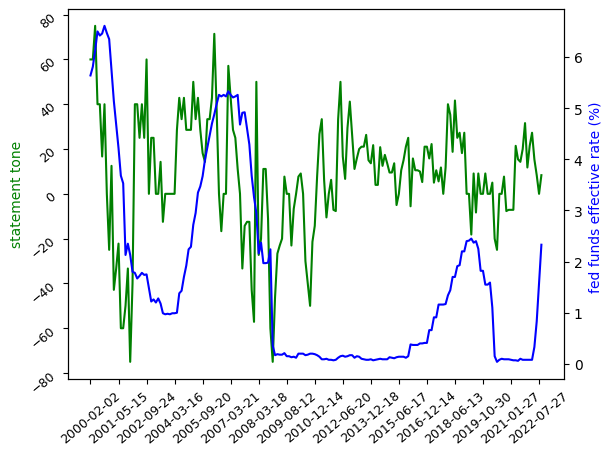

In [71]:
# plotting sentiment as in Tadle 2022 with the fed funds rate
for date in df.index:
    df.loc[date, 'fr'] = df_fed_funds.loc[date, 'DFF']
    
x = df.index

y1 = df['tadle_score']
y2 = df['fr']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
plt.xticks(np.arange(0, len(x) + 1, 12))
ax1.tick_params(labelrotation=40, labelsize=9)

ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_ylabel('statement tone', color='g')
ax2.set_ylabel('fed funds effective rate (%) ', color='b')
plt.show()

In [72]:
# add fed funds rate for each statement date

for date in df.index:
    df.loc[date, 'fr'] = df_fed_funds.loc[date, 'DFF']

min_year = df[df['tadle_score'] == min(df['tadle_score'])].index.values[1]

str_min = df['full_text'].loc[min_year]

# Measuring statement tone using Jaccard distance

In [73]:
# calculating alternative measure of sentiment usng Jaccard distance
## levenshtein distance left commented out only for illustration purposes

# df['dist'] = df.apply(lambda xxx: levenshtein_distance(xxx['full_text'], str_min), axis=1)
# df['length'] = df['full_text'].str.len()
# df['lev_dist'] = df['dist'] / df['length']

df['my_score'] = df['full_text'].apply(calc_distance)

# print(np.corrcoef(df['lev_dist'].values, df['tadle_score'].values)[0, 1])

In [74]:
# calculating correlation between my score and tadle's score

np.corrcoef(df['my_score'].values, df['tadle_score'].values)[0, 1]

0.28011352668466233

In [75]:
#export results

df.to_csv(r'/Users/christianpavilanis/Downloads/hawkishness.csv')

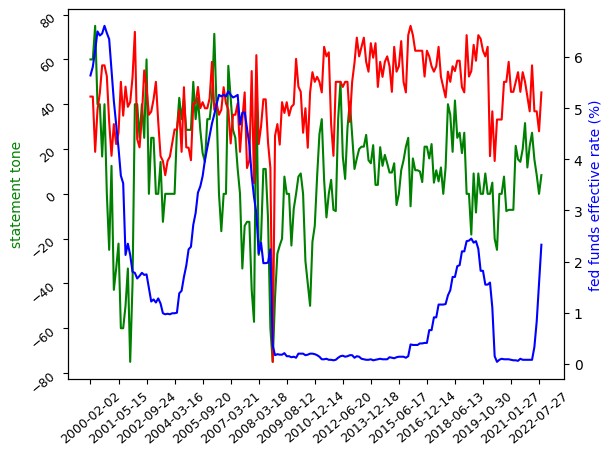

In [76]:
# adding my measure to previous plot
x = df.index

y1 = df['tadle_score']
y2 = df['fr']
y3 = df['my_score']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
plt.xticks(np.arange(0, len(x) + 1, 12))
ax1.tick_params(labelrotation=40, labelsize=9)

ax1.plot(x, y1, 'g-')
ax1.plot(x, y3, 'r-')
ax2.plot(x, y2, 'b-')

ax1.set_ylabel('statement tone', color='g')
ax2.set_ylabel('fed funds effective rate (%)', color='b')
plt.show()